In [1]:
%pylab inline
import scipy.stats

from sigvisa.infer.correlations.proposal_signal_likelihood import likelihood_windowed, arbaseline, iidbaseline, preprocess_historical
from sigvisa.infer.correlations.weighted_event_posterior import build_ttr_model_array, atime_likelihood_to_origin_likelihood, wn_origin_posterior, ev_time_posterior_with_weight
#import seaborn as sns
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference
from sigvisa.models.noise.noise_util import get_noise_model
from sigvisa.database.dataset import DET_TIME_COL

Populating the interactive namespace from numpy and matplotlib


In [147]:
#from sigvisa.experiments.aftershock_region import evids, stas
import cPickle as pickle

stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']

doublet = 5335822# 5334939

#evids = [5334501, 5334726, 5335822, 5349536, 
#         5336237, 5335424, 5349441, 
#         5336889, 5336015]
evids = [doublet,]

rs = EventRunSpec(evids=evids, stas=stas, runids=(1,), disable_conflict_checking=True)
ms = ModelSpec(template_model_type="param", wiggle_family="iid", 
               max_hz=10.0, inference_preset="openworld", raw_signals=True)
sg = rs.build_sg(ms)

with open("corr.sg", 'wb') as f:
    pickle.dump(sg, f)
    
#with open("corr.sg", 'rb') as f:
#    sg = pickle.load(f)

1240241574.19 1240241704.19
1240241947.78 1240242077.78
1240241740.22 1240241870.22
1240241508.35 1240241638.35


In [148]:
from sigvisa.source.event import get_event
evid = 5336015

def extract_template(wave, atime, len_s):
    nm, nmid, _ = get_noise_model(waveform=wave, model_type="ar", order=0, return_details=True)
    sigma2_A = nm.em.std**2
    aidx = int((atime - wave['stime'])*wave['srate'])
    n = int(len_s * wave['srate'])
    A = wave.data[aidx:aidx+n]
    return A, sigma2_A

from sigvisa.signals.io import load_event_station_chan
def extract_template_from_leb(sta, evid, chan="auto", band="freq_2.0_4.5"):
    w =  load_event_station_chan(evid, sta, chan, evtype="leb")
    w = w.filter("%s;hz_10" % band)
    atime =  w['event_arrivals'][0,DET_TIME_COL]
    A, sigma2_A = extract_template(w, atime, 10)
    return A, sigma2_A

templates = []
tau = 0.95

history = dict()
n=100
for sta in sg.station_waves.keys():
    try:
        A, sigma2_A = extract_template_from_leb(sta, evid)
        n = len(A)
        alpha_hat = np.sqrt(np.dot(A, A)/n - sigma2_A)

        c = tau*alpha_hat/(alpha_hat**2+sigma2_A) * A
        kappa = 1 - alpha_hat**2 * tau**2 / (alpha_hat**2 + sigma2_A)
    except Exception as e:
        print e
        c = np.zeros((n,))
        kappa = 1
    history[sta] = (c, kappa)


1240288288.17 1240288498.17
1240287846.46 1240288056.46
1240287915.75 1240288125.75
no arrivals found for evid 5336015 at station CM16


In [149]:
evtgt = get_event(doublet)

wn = sg.station_waves["MK31"][0]
sdata = wn.get_value()
sigma2_B = np.std(sdata)**2
baseline, unobs_lp = iidbaseline(sdata, len(c))
lls2 = likelihood_windowed(sdata, c, kappa, sigma2_B) + baseline


In [156]:
ev = get_event(evid)

global_ll = ev_time_posterior_with_weight(sg, ev, history, global_stime=evtgt.time-300, N=600, global_srate=1.0)



-11169.6284114


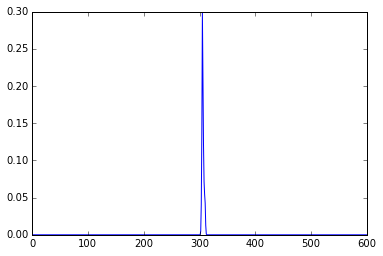

In [157]:
C = np.max(global_ll)
posterior = np.exp(global_ll-C)
Z = np.sum(posterior)
posterior /= Z
logZ = np.log(Z) + C
plot(posterior)
print logZ